# Punto 3 Comparación de Rendimiento con GLPK/Pyomo

## Solución por medio de Simplex

Gilmoire Girls

In [1]:
import numpy as np
import pandas as pd

Para el primer paso se ingresan los datos del enunciado, incluyendo la matriz de coeficientes de restricciones (A), los terminos independientes y los coeficientes de la función objetivo.

In [2]:

restricciones = np.array([
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1], 
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1]
], dtype=float)

soluciones = np.array([50, 60, 55, 40, 45, 70, 65, 50], dtype=float).reshape(-1, 1)
z = np.array([[-5, -8, -3, -7, -6, -9, -4, -10, -2, -11]], dtype=float)


Como todas las restricciones son de la forma $\le$, se tienen que crear las variables de holgura para cada una de las filas para que las restricciones sean de tipo $=$:


In [3]:
num_restricciones = restricciones.shape[0]
holguras = np.eye(num_restricciones)
restricciones_conholguras = np.hstack((restricciones, holguras))
#Toca añadir un array de 0s a la fila de Z
z_con_holguras = np.hstack((z, np.zeros((1, num_restricciones))))

In [4]:
tabla = np.hstack((restricciones_conholguras, soluciones))
tabla = np.vstack((tabla, np.append(z_con_holguras, 0)))

columnas = [f'x{i+1}' for i in range(10)]
holguras = [f'h{i+1}' for i in range(num_restricciones)]
real_col = columnas + holguras + ["solucion"]
index = holguras + ["Z"]

df = pd.DataFrame(tabla, columns=real_col, index=index)
print(df)

     x1   x2   x3   x4   x5   x6   x7    x8   x9   x10   h1   h2   h3   h4  \
h1  1.0  2.0  1.0  1.0  0.0  0.0  3.0   1.0  2.0   1.0  1.0  0.0  0.0  0.0   
h2  2.0  1.0  0.0  2.0  1.0  1.0  0.0   3.0  1.0   2.0  0.0  1.0  0.0  0.0   
h3  1.0  1.0  2.0  0.0  2.0  1.0  1.0   0.0  3.0   1.0  0.0  0.0  1.0  0.0   
h4  0.0  2.0  1.0  1.0  1.0  0.0  2.0   1.0  1.0   1.0  0.0  0.0  0.0  1.0   
h5  2.0  0.0  1.0  1.0  1.0  2.0  1.0   1.0  0.0   2.0  0.0  0.0  0.0  0.0   
h6  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  1.0   1.0  0.0  0.0  0.0  0.0   
h7  0.0  1.0  2.0  1.0  0.0  1.0  2.0   1.0  1.0   0.0  0.0  0.0  0.0  0.0   
h8  1.0  0.0  1.0  2.0  1.0  0.0  1.0   2.0  1.0   1.0  0.0  0.0  0.0  0.0   
Z  -5.0 -8.0 -3.0 -7.0 -6.0 -9.0 -4.0 -10.0 -2.0 -11.0  0.0  0.0  0.0  0.0   

     h5   h6   h7   h8  solucion  
h1  0.0  0.0  0.0  0.0      50.0  
h2  0.0  0.0  0.0  0.0      60.0  
h3  0.0  0.0  0.0  0.0      55.0  
h4  0.0  0.0  0.0  0.0      40.0  
h5  1.0  0.0  0.0  0.0      45.0  
h6  0.0  

### Definifición de funciones del punto 2

Para realizar la optimización se tienen 3 funciones principales:
- revisar_maximizacion(tabla): revisa la condición de parada de la tabla de simplex. Si encuentra que hay algún coeficiente negativo en la fila de $Z$, significa que aún se puede optimizar más. Si no encuentra ningún negativo, ya se llegó al óptimo. 
- pivote(tabla, num_fila_piv, num_col_piv): Reacibiendo la tabla actual, el numero de la columna que entra y la fila que sale, realiza las transformaciones necesarias para realizar el pivote.
- solver_minimizacion(tabla): Lógica principal del proceso de simplex. Recibe la tabla con los coeficientes de ambos las variables de restricción y las variables de holgura, y realiza el proceso de optimización por medio de simplex hasta que revisar_maximizacion devuelva False.

In [5]:
def revisar_maximizacion(tabla):
    return any(var<0 for var in tabla[-1,:-1])

def pivote(tabla, num_fila_piv, num_col_piv):
    nueva_tabla = tabla.copy()

    #Se toma solo la fila pivote, se edita y se devuelve a la tabla
    fila_pivote = nueva_tabla[num_fila_piv, :].copy()
    pivote_elemento = fila_pivote[num_col_piv]
    fila_pivote = fila_pivote / pivote_elemento
    nueva_tabla[num_fila_piv, :] = fila_pivote

    for i in range(nueva_tabla.shape[0]):
        if i != num_fila_piv:
            fila_actual = nueva_tabla[i, :].copy()
            coef = fila_actual[num_col_piv]
            nueva_tabla[i, :] = fila_actual - (coef * fila_pivote)

    return nueva_tabla




def solver_minimizacion(tabla, filas, columnas):
    iteracion = 1
    
    while revisar_maximizacion(tabla):
        print (f"Iteración {iteracion}:")
        columna = np.argmin(tabla[-1,:-1])
        print (f"Columna pivote:  {columna}. Entra la variable {columnas[columna]} como básica")       
        #Encontrar la fila pivote
        num_fila = 0
        ratios = []
        for i in range(tabla[:-1].shape[0]):
            if tabla[i, columna] > 0:
                posible = tabla[i, -1] / tabla[i, columna]
                ratios.append(posible)
            else:
                ratios.append(np.inf)

        
        num_fila = np.argmin(ratios)
        print (f"Fila pivote:  {num_fila}. Sale la variable {filas[num_fila]} como básica.") 
        filas[num_fila] = columnas[columna]
        tabla = pivote(tabla, num_fila, columna)
        print("tabla actual:")
        print (pd.DataFrame(tabla, columns=columnas, index=filas))
        iteracion+=1
    print("Solución encontrada!!: ")
    return tabla


        

Da una solución viable. Posteriormente se generará una función que agrupe todos los procesos necesarios para resolver el proble,a y poder hacer una toma de tiempo

# Automatización del proceso para medir tiempos


In [6]:
import time

Esta es la función que recibe los datos de entrada (`restricciones`, `soluciones`, `z`) y calcula el óptimo, primero realizando las transformaciones necesarias a la tabla original para crear las variables de holgura, y luego realizando el llamado a `solver_minimización`

In [7]:
def automatizacion(restricciones,soluciones,z):
    num_restricciones = restricciones.shape[0]
    holguras = np.eye(num_restricciones)
    restricciones_conholguras = np.hstack((restricciones, holguras))
    #Toca añadir un array de 0s a la fila de Z
    z_con_holguras = np.hstack((z, np.zeros((1, num_restricciones))))
    tabla = np.hstack((restricciones_conholguras, soluciones))
    tabla = np.vstack((tabla, np.append(z_con_holguras, 0)))

    columnas = [f'x{i+1}' for i in range(10)]
    holguras = [f'h{i+1}' for i in range(num_restricciones)]
    real_col = columnas + holguras + ["solucion"]
    index = holguras + ["Z"]
    tabla = solver_minimizacion(tabla, index, real_col)
    df = pd.DataFrame(tabla, columns=real_col, index=index)
    print(df)

#Acá se mide el tiempo
start_time = time.time()
automatizacion(restricciones=restricciones, soluciones= soluciones, z=z)
entd_time = time.time()
print(f"El tiempo que se demoró en encontrar el óptimo fue de {entd_time-start_time}ms")

Iteración 1:
Columna pivote:  9. Entra la variable x10 como básica
Fila pivote:  4. Sale la variable h5 como básica.
tabla actual:
      x1   x2   x3   x4   x5   x6   x7   x8   x9  x10   h1   h2   h3   h4  \
h1   0.0  2.0  0.5  0.5 -0.5 -1.0  2.5  0.5  2.0  0.0  1.0  0.0  0.0  0.0   
h2   0.0  1.0 -1.0  1.0  0.0 -1.0 -1.0  2.0  1.0  0.0  0.0  1.0  0.0  0.0   
h3   0.0  1.0  1.5 -0.5  1.5  0.0  0.5 -0.5  3.0  0.0  0.0  0.0  1.0  0.0   
h4  -1.0  2.0  0.5  0.5  0.5 -1.0  1.5  0.5  1.0  0.0  0.0  0.0  0.0  1.0   
x10  1.0  0.0  0.5  0.5  0.5  1.0  0.5  0.5  0.0  1.0  0.0  0.0  0.0  0.0   
h6   0.0  1.0  0.5  0.5  0.5  0.0  0.5  0.5  1.0  0.0  0.0  0.0  0.0  0.0   
h7   0.0  1.0  2.0  1.0  0.0  1.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
h8   0.0  0.0  0.5  1.5  0.5 -1.0  0.5  1.5  1.0  0.0  0.0  0.0  0.0  0.0   
Z    6.0 -8.0  2.5 -1.5 -0.5  2.0  1.5 -4.5 -2.0  0.0  0.0  0.0  0.0  0.0   

      h5   h6   h7   h8  solucion  
h1  -0.5  0.0  0.0  0.0      27.5  
h2  -1.0  0.0  0.0  0.0   

## Solución con pyomo

In [2]:
from pyomo.environ import *
import time
model = ConcreteModel()
model.T= RangeSet(1,10)
c = [5, 8, 3, 7, 6, 9, 4, 10, 2, 11]
model.x = Var(model.T, domain=NonNegativeReals)
model.obj = Objective(expr=sum(c[i-1]*model.x[i] for i in model.T), sense=maximize)
model.tareas = ConstraintList()


A = [
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1]
]
b = [50, 60, 55, 40, 45, 70, 65, 50]
for j in range(8):
    model.tareas.add(expr=sum(A[j][i] * model.x[i + 1] for i in range(10)) <= b[j])

for n in range(10):
    model.tareas.add(model.x[n+1] >=0)

from pyomo.opt import SolverFactory
start_time_2 = time.time()
solver = SolverFactory('glpk')
#solver.options['display'] = 'iter'
solver.solve(model, )
entd_time_time_2 = time.time()

print("Máximo valor:", model.obj())
print("Coeficientes a cada variable:")
for i in model.T:
    print(f"Variable x_{i}: {model.x[i].value}")
print(f"El tiempo que se demoró en encontrar el óptimo fue de {entd_time_time_2-start_time_2}ms")


Máximo valor: 375.625
Coeficientes a cada variable:
Variable x_1: 0.0
Variable x_2: 15.625
Variable x_3: 0.0
Variable x_4: 0.0
Variable x_5: 0.0
Variable x_6: 18.125
Variable x_7: 0.0
Variable x_8: 8.75
Variable x_9: 0.0
Variable x_10: 0.0
El tiempo que se demoró en encontrar el óptimo fue de 0.07819104194641113ms


# Comparación de Tiempos: 

Para realizar una comparación de tiempos, se decidió realizar una toma de pruebas de 10 intentos para resolver el mismo problema de optimización, midiendo los tiempos en cada una de las pruebas y posteriormente comparandolas:


| Intento   | Simplex      | Pyomo     |
|-----------|--------------|-----------|
| P1        | 0.0808002948 |0.1571209  |
| P2        | 0.06989431   |0.1290121  |
| P3        | 0.068294525  |0.0947446  |
| P4        | 0.06490731   |0.1280491  |
| P5        | 0.076535463  |0.1198186  |
| P6        | 0.07329273   |0.1164553  |
| P7        | 0.07329273   |0.1114282  |
| P8        | 0.0751767158 |0.1159241  |
| P9        | 0.071909666  |0.1199952  |
| P10       | 0.0613899230 |0.0781910  |


Todas las medidas de ambos el método Simplex como pyomo están en milisegundos (ms)
Con esta información se realizó un gráfico de comparación entre los 2 métodos operando sobre el mismo ejercicio de optimización:

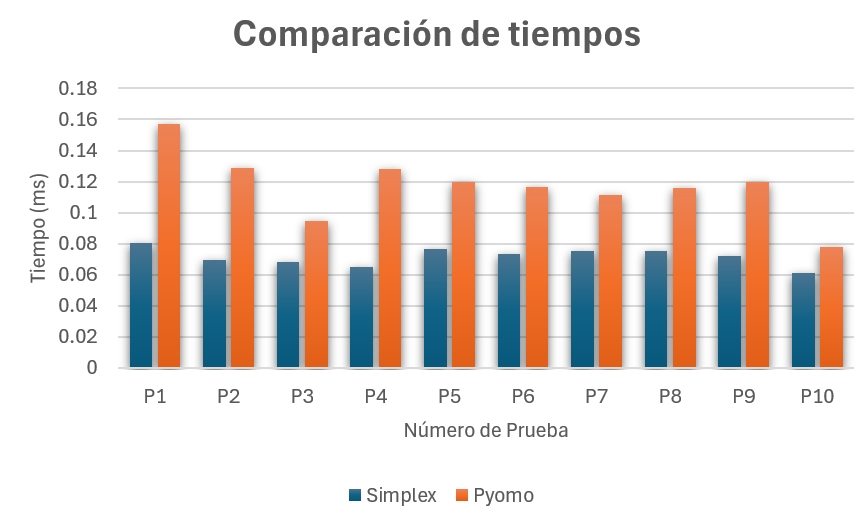

De este gráfico se puede evidenciar que, aunque actualmente el método Simplex es consistentemente más rápido, pero no por mucho, incluso para la prueba número 10, se evidencia que la diferencia entre desempeños es de tan solo 0.017ms. 
Sin embargo, las pruebas se hicieron con un caso pequeño (8 restricciones y 10 variables), por lo que es probable que no se pueda generalizar que Simplex tiene un mejor desempeño en todos los casos. El proceso de encontrar la columna y fila pivote y luego hacer las transformaciones necesarias en cada paso son costosas, por lo que muy probablemente, si se prueba con un caso sustancialmente mayor (por ejemplo, 30 variables), es muy probable que el método de Pyomo tenga un mejor rendimiento. Actualmente, se puede asumir que una porción considerable del tiempo que se demora en resolver el problema es generando el modelo, es decir, pasando los atributos, constraints, etc, al modelo de GLPK. Este tiempo afecta considerablemente el tiempo de un problema pequeño, pero si se fuera a probar con un problema mucho más complejo, posiblemente esta demora en construir el modelo sea la misma, y para ese caso, ya no es tan considerable. Es por esto que se puede asumir que el método de Pyomo, más específicamente el de GLPK, seguramente tiene una mejor escalabilidad al resolver problemas mayores.